In [1]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

from umap import UMAP

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.decomposition import PCA

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


/home/jc225751/Runs/70_self-supervised_two-regions/Program/venv_natif/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/hcp/Handedness/handedness_labels.csv"
embeddings_subpath = "hcp_random_embeddings/full_embeddings.csv"
participants_ukb_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
embeddings_ukb_subpath = "ukb_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/isRightHanded_hcp_with_residualization.csv"
label = "isRightHanded"
covariates = ["Sex", "Age"]
max_iter = 2000
cv = 3

In [3]:
def compute_umap(df, n_neighbors=15, n_components=2):
    # apply umap
    reducer = UMAP(n_neighbors=n_neighbors, n_components=n_components)
    visual_embs = reducer.fit_transform(df)
    return visual_embs, reducer

In [4]:
participants = pd.read_csv(participants_file, index_col=0)
participants

,Handedness,Age,Gender,isRightHanded,isStronglyRightHanded
Subject,,,,,
100004,95,24,M,1.0,1.0
100206,65,27,M,1.0,NaN
100307,95,27,F,1.0,1.0
100408,55,33,M,1.0,NaN
100610,85,27,M,1.0,1.0
...,...,...,...,...,...
992774,100,35,M,1.0,1.0
993675,85,29,F,1.0,1.0
994273,60,30,M,1.0,NaN


In [5]:
participants["Sex"] = (participants["Gender"] == 'M').astype(int)

In [6]:
participants_ukb = pd.read_csv(participants_ukb_file, index_col=0)

In [7]:
participants

,Handedness,Age,Gender,isRightHanded,isStronglyRightHanded,Sex
Subject,,,,,,
100004,95,24,M,1.0,1.0,1
100206,65,27,M,1.0,NaN,1
100307,95,27,F,1.0,1.0,0
100408,55,33,M,1.0,NaN,1
100610,85,27,M,1.0,1.0,1
...,...,...,...,...,...,...
992774,100,35,M,1.0,1.0,1
993675,85,29,F,1.0,1.0,0
994273,60,30,M,1.0,NaN,1


In [8]:
participants = participants[[label] + covariates].dropna()

array([[<Axes: title={'center': 'isRightHanded'}>,
        <Axes: title={'center': 'Sex'}>],
       [<Axes: title={'center': 'Age'}>, <Axes: >]], dtype=object)

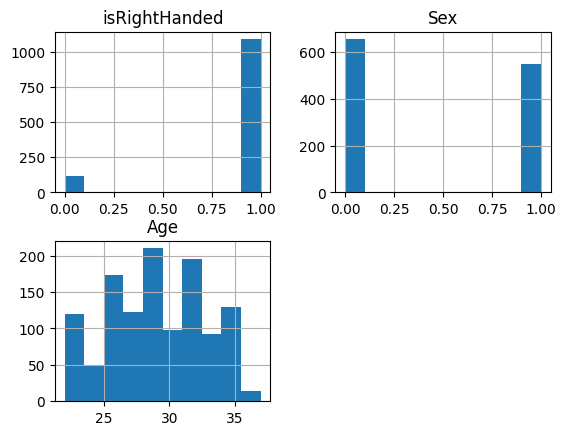

In [9]:
participants.hist()

In [10]:
print(len(participants[participants.isRightHanded==0]))
print(len(participants[participants.isRightHanded==1]))

113
1089


array([[<Axes: title={'center': 'Sex'}>, <Axes: title={'center': 'Age'}>]],
      dtype=object)

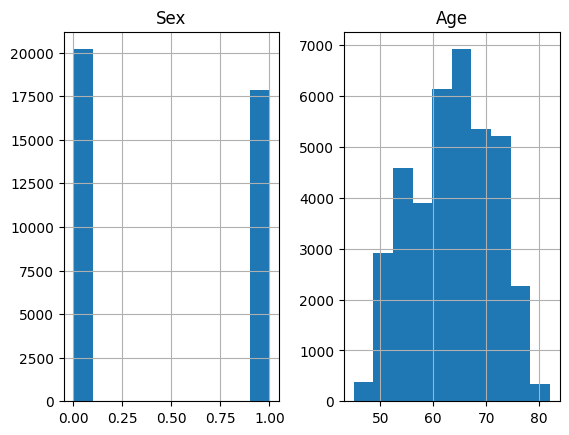

In [11]:
participants_ukb = participants_ukb[covariates].dropna()
participants_ukb.hist()

In [12]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [13]:
model_paths = get_model_paths(path_champollion)

In [14]:
model_paths[:5]

['/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1']

In [15]:
def compute(model_path):
    global embeddings
    global participants
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label] + covariates].merge(embeddings, left_index=True, right_index=True)

    # Residualizes using ukb embeddings
    embeddings_ukb = pd.read_csv(f"{model_path}/{embeddings_ukb_subpath}", index_col=0)
    phenotypes_cols = embeddings_ukb.columns # Supposes that phenotype names are identical
    merged_ukb = participants_ukb[covariates].merge(embeddings_ukb, left_index=True, right_index=True)

    resid_df = merged[[label]].copy()
    resid_df.loc[:, phenotypes_cols] = 0.0
    for dim_i in phenotypes_cols:
        X = merged_ukb[covariates]
        X = sm.add_constant(X)
        y = merged_ukb[dim_i]
        model = sm.OLS(y, X).fit()

        X = merged[covariates]
        X = sm.add_constant(X)
        y = merged[dim_i]
        ypred = model.predict(X)
        residuals = y - ypred
        resid_df.loc[:, dim_i] = residuals
    
    # Merge
    merged = participants[[label]].merge(resid_df[phenotypes_cols], left_index=True, right_index=True)
    
    # Classifies
    X = merged.drop([label], axis=1)
    Y = merged[[label]]
    df2, _ = compute_umap(X, n_neighbors=15, n_components=20)
    df2 = pd.DataFrame(df2)
    df2.index = X.index
    scaler = StandardScaler()
    df2[df2.columns] = scaler.fit_transform(df2)

    # Makes OLS
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y[label], df2)
    results = model.fit()
    f_value = results.fvalue
    p_value = results.f_pvalue
    
    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(f_value, p_value)
    
    # Returns result
    return (region, f_value, p_value, model_name, region_path, model_path)

In [16]:
result = []
for model_path in model_paths:
    result.append(compute(model_path))

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2


/home/jc225751/Runs/70_self-supervised_two-regions/Program/venv_natif/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


1.4691860788604727 0.08317825092641548
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
1.6025881440650716 0.04485885201785131
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
0.7280962477469558 0.7997022819167547
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
0.9917059166857364 0.4693563759937689
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
1.2314003819226382 0.21892104776874025
Treating S.C.-sylv._right: SC-sylv_right/11-43-38_3 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_right/11-43-38_3
1.590552540213419 0.04752068691403283


In [17]:
df = pd.DataFrame(result, columns=['region', 'f_value', 'p_value', 'model_name', 'region_path', 'model_path'])

In [18]:
df

,region,f_value,p_value,model_name,region_path,model_path
0,S.C.-sylv._left,1.469186,0.083178,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...
1,S.C.-sylv._left,1.602588,0.044859,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...
2,S.F.inter.-S.F.sup._left,0.728096,0.799702,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...
3,S.T.i.-S.T.s.-S.T.pol._right,0.991706,0.469356,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...
4,F.Coll.-S.Rh._right,1.231400,0.218921,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...
...,...,...,...,...,...,...
72,S.F.inter.-S.F.sup._right,1.418931,0.103607,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...
73,S.T.s._left,1.620895,0.041065,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...
74,F.C.M.post.-S.p.C._right,0.897865,0.590201,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...
75,ORBITAL_right,0.784960,0.734139,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...


In [19]:
df['side'] = df['region'].str.split('_').str[-1]

In [20]:
df

,region,f_value,p_value,model_name,region_path,model_path,side
0,S.C.-sylv._left,1.469186,0.083178,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...,left
1,S.C.-sylv._left,1.602588,0.044859,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...,left
2,S.F.inter.-S.F.sup._left,0.728096,0.799702,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...,left
3,S.T.i.-S.T.s.-S.T.pol._right,0.991706,0.469356,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...,right
4,F.Coll.-S.Rh._right,1.231400,0.218921,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right
...,...,...,...,...,...,...,...
72,S.F.inter.-S.F.sup._right,1.418931,0.103607,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...,right
73,S.T.s._left,1.620895,0.041065,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...,left
74,F.C.M.post.-S.p.C._right,0.897865,0.590201,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...,right
75,ORBITAL_right,0.784960,0.734139,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...,right


In [21]:
def plot_horizontal(res, region_name, ax, f_value, p_value, f2_value, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=f_value, ascending=True)
    res[f2_value] = -np.log10(res[f2_value])

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=-np.log10(0.05/56), color='black', linestyle='-')
    ax.barh(res[region_name], res[f2_value], fill=True, color='lightgray')
    ax.errorbar(res[f_value], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    # ax.set_xlim((0.3, 1.0))
    ax.set_title(title)

In [22]:
df[df.region=="F.I.P._right"].sort_values(by="f_value", ascending=False)

,region,f_value,p_value,model_name,region_path,model_path,side
58,F.I.P._right,2.586664,0.000160,20-16-33_3,FIP_right/20-16-33_3,/neurospin/dico/data/deep_folding/current/mode...,right
55,F.I.P._right,2.341220,0.000747,20-16-33_2,FIP_right/20-16-33_2,/neurospin/dico/data/deep_folding/current/mode...,right
56,F.I.P._right,2.266631,0.001175,20-16-33_0,FIP_right/20-16-33_0,/neurospin/dico/data/deep_folding/current/mode...,right
53,F.I.P._right,2.103176,0.003093,14-24-09_213_joel,FIP_right/14-24-09_213_joel,/neurospin/dico/data/deep_folding/current/mode...,right
57,F.I.P._right,1.846107,0.012995,20-16-33_4,FIP_right/20-16-33_4,/neurospin/dico/data/deep_folding/current/mode...,right
54,F.I.P._right,1.736005,0.023128,20-16-33_1,FIP_right/20-16-33_1,/neurospin/dico/data/deep_folding/current/mode...,right


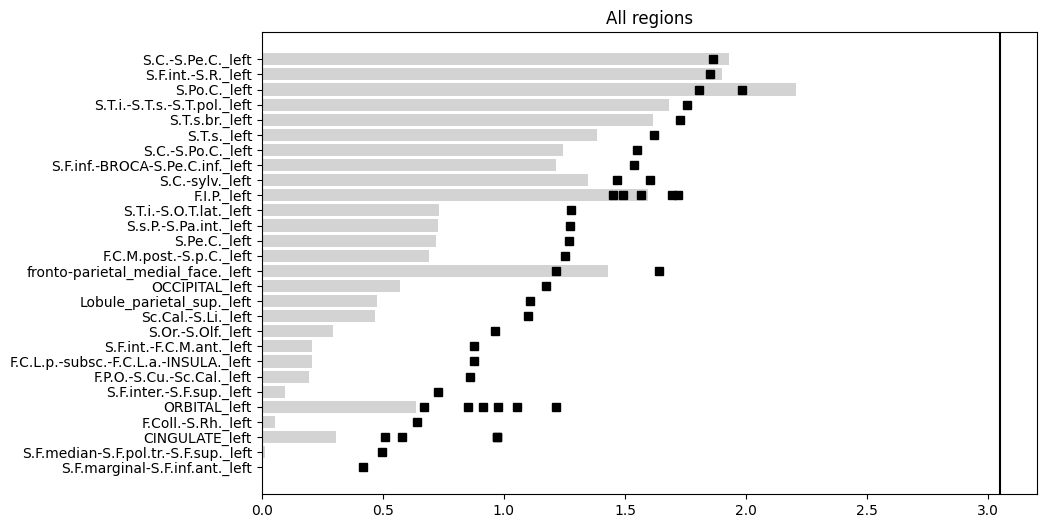

In [23]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "f_value", "f_value", "p_value",  True, "All regions")
plt.show()

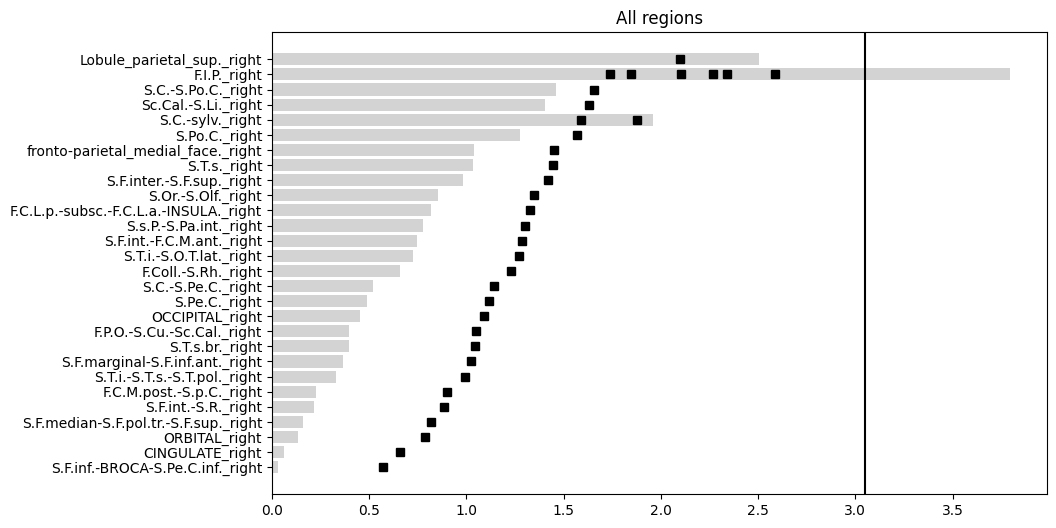

In [24]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "f_value", "p_value", "p_value",  True, "All regions")
plt.show()

In [25]:
df

,region,f_value,p_value,model_name,region_path,model_path,side
0,S.C.-sylv._left,1.469186,0.083178,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...,left
1,S.C.-sylv._left,1.602588,0.044859,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...,left
2,S.F.inter.-S.F.sup._left,0.728096,0.799702,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...,left
3,S.T.i.-S.T.s.-S.T.pol._right,0.991706,0.469356,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...,right
4,F.Coll.-S.Rh._right,1.231400,0.218921,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right
...,...,...,...,...,...,...,...
72,S.F.inter.-S.F.sup._right,1.418931,0.103607,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...,right
73,S.T.s._left,1.620895,0.041065,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...,left
74,F.C.M.post.-S.p.C._right,0.897865,0.590201,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...,right
75,ORBITAL_right,0.784960,0.734139,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...,right


In [26]:
df.to_csv(output_filename)